## Campus placement prediction

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')


### Importing the dataset
Dataset link: [Campus Recruitment Dataset](https://www.kaggle.com/datasets/gauravduttakiit/campus-recruitment/data)

In [2]:
campusDataset = pd.read_csv('PlacementData.csv')

In [41]:
campusDataset.head(10)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,etest_p,mba_p,specialisation,workex,status
0,M,73.976975,Central,77.392691,Others,Science,73.623151,Sci&Tech,84.498310,67.207006,Mkt&HR,Yes,Placed
1,M,62.000000,Others,62.000000,Others,Commerce,60.000000,Comm&Mgmt,63.000000,52.380000,Mkt&HR,Yes,Placed
2,M,80.965242,Others,67.104275,Others,Science,72.482621,Sci&Tech,91.343588,71.392313,Mkt&Fin,No,Placed
3,M,52.000000,Others,65.000000,Others,Arts,57.000000,Others,75.000000,59.810000,Mkt&Fin,Yes,Not Placed
4,F,69.000000,Central,62.000000,Central,Science,66.000000,Sci&Tech,75.000000,67.990000,Mkt&HR,No,Not Placed
5,M,78.762370,Others,78.663054,Others,Commerce,70.281069,Comm&Mgmt,67.441772,65.318049,Mkt&Fin,Yes,Placed
6,M,51.794497,Others,40.985605,Others,Science,62.126648,Others,65.862469,52.249751,Mkt&HR,No,Not Placed
7,M,59.805924,Central,61.451481,Others,Commerce,60.000000,Comm&Mgmt,62.451481,57.025957,Mkt&HR,Yes,Placed
8,M,77.351318,Central,74.834674,Others,Science,73.487712,Sci&Tech,80.123994,68.001657,Mkt&HR,Yes,Placed
9,M,76.500000,Others,97.700000,Others,Science,78.860000,Sci&Tech,97.400000,74.010000,Mkt&Fin,No,Placed


### Exploring the Data

Looking into class imbalance:

In [3]:
print(pd.value_counts(campusDataset['status']))

status
Placed        439
Not Placed    231
Name: count, dtype: int64


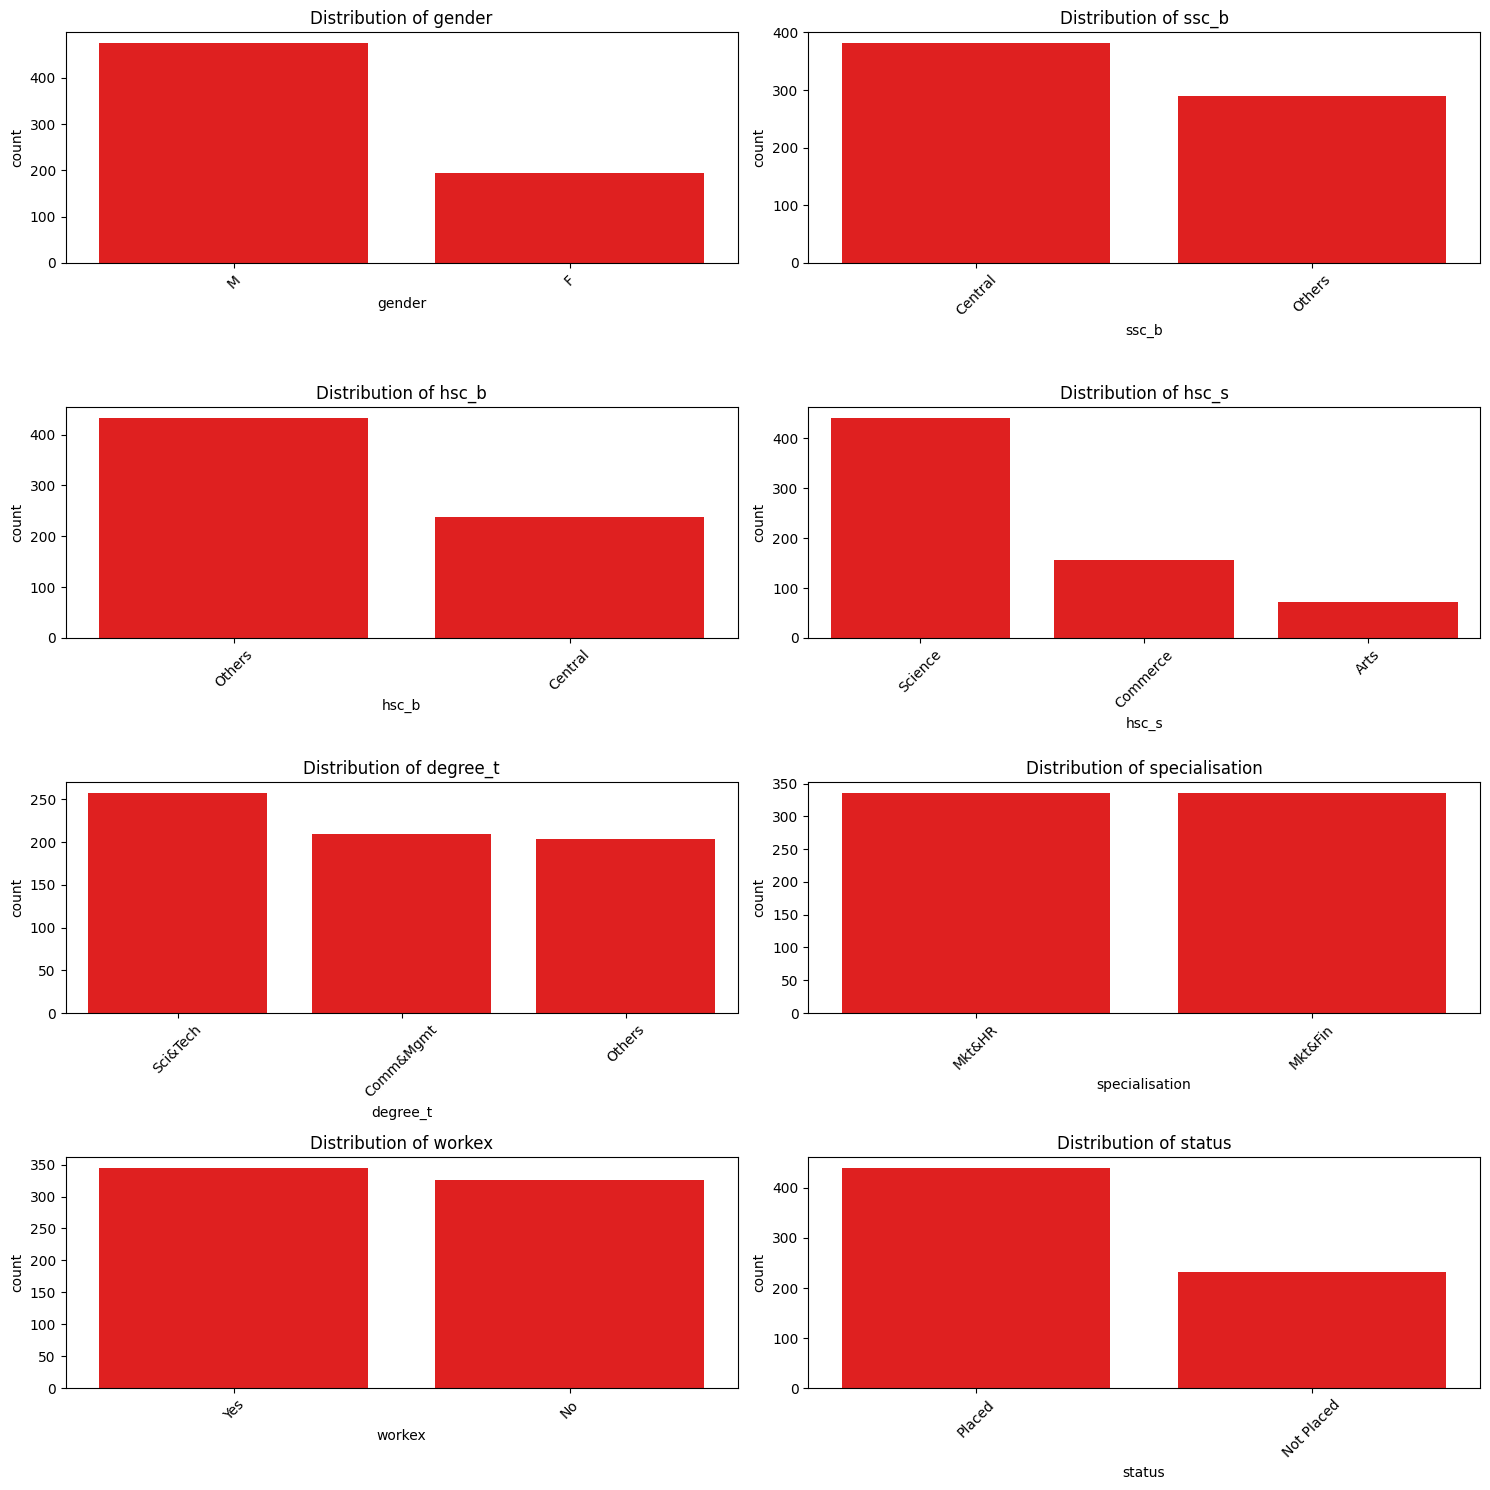

In [13]:
categorical_columns = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'specialisation', 'workex', 'status']
fig, axes = plt.subplots(4, 2, figsize=(15, 15)) 
axes = axes.flatten()
for i, column in enumerate(categorical_columns):
    if i < 8: 
        sns.countplot(x=column, data=campusDataset, ax=axes[i], color='red')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].tick_params(axis='x', rotation=45)  
plt.tight_layout()
plt.show()

From the plots, we can say that: 
1. **Gender Distribution**: There are significantly more males than females represented in the dataset.
2. **SSC Board**: Most candidates come from the Central board as compared to others.
3. **HSC Board**: Similarly to SSC, the Central board is more common among candidates for higher secondary education as well.
4. **HSC Stream**: Science is the most common stream, followed by Commerce, and then Arts, indicating a possible technical or commerce-oriented focus in the dataset.
5. **Degree Type**: The distribution shows a good mix of degree types, with Commerce/Law and Science/Tech having higher representations.
6. **Work Experience**: A larger number of candidates have no work experience compared to those who do.
7. **Specialisation**: More candidates have a Marketing & HR specialization compared to Marketing & Finance.
8. **Status**: There are more candidates placed than not placed, suggesting a relatively successful placement rate.


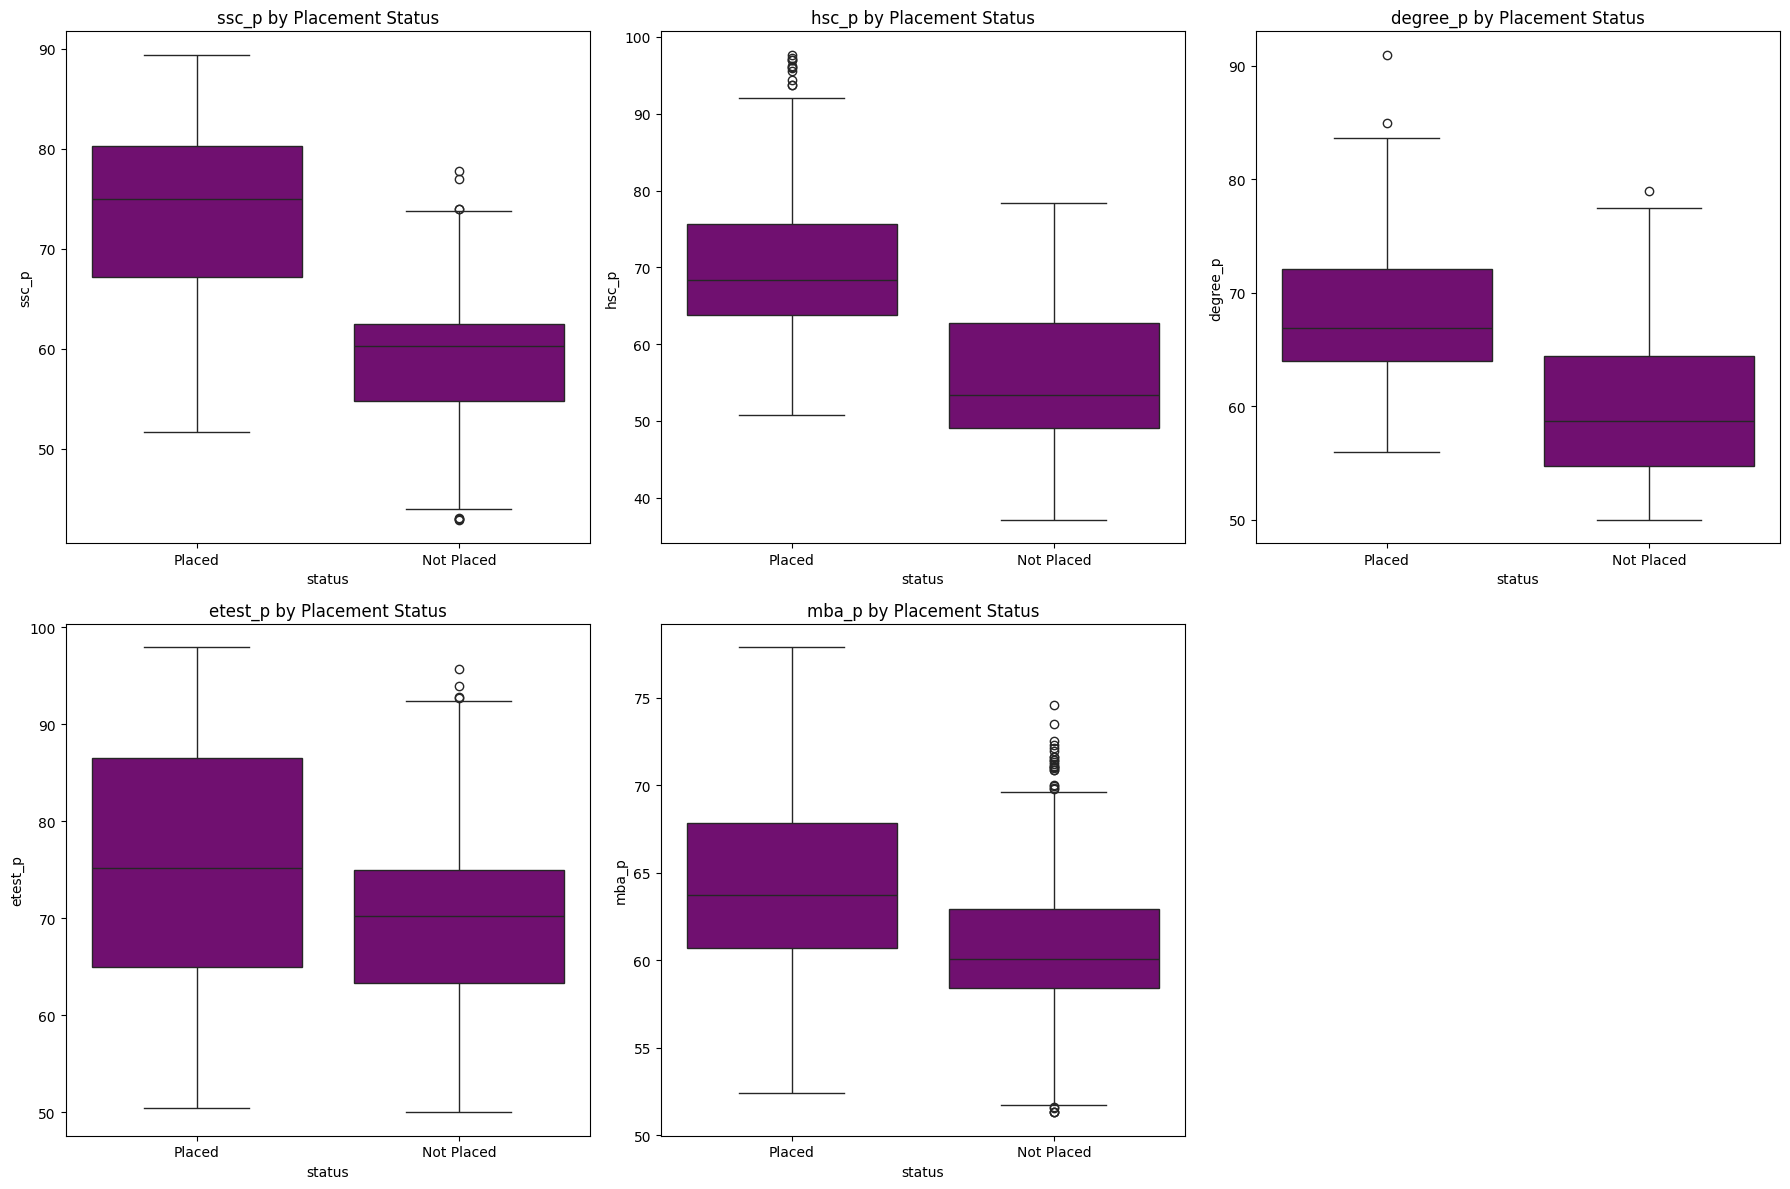

In [18]:
numerical_columns = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  
for i, column in enumerate(numerical_columns):
    sns.boxplot(x='status', y=column, data=campusDataset, ax=axes[i], color='purple')
    axes[i].set_title(f'{column} by Placement Status')
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

We can see the following based on the boxplots comparing academic performance and placement status:
1. **SSC Percentage (ssc_p)**:
   - Students who are placed generally have a higher SSC percentage. The median score for placed students is above 70%, while for those not placed, it is below 70%.
   - There are more outliers in the non-placed category with lower scores, indicating that lower SSC scores may negatively impact placement chances.

2. **HSC Percentage (hsc_p)**:
   - Similar to SSC results, higher HSC scores are associated with placements. The median HSC score for placed students is considerably higher than for those not placed.
   - Variability in scores is slightly higher among non-placed students, shown by a longer whisker in the boxplot.

3. **Degree Percentage (degree_p)**:
   - There's a clear difference in degree percentages between placed and not placed students, with placed students having higher median scores.
   - The degree scores show a considerable number of high-performing outliers in the placed category.

4. **Employability Test Percentage (etest_p)**:
   - Employability test scores do not show as clear a division between placed and not placed students as academic scores do. Both groups show a wide range of scores.
   - The median score is higher for placed students, but the difference is not as marked as with academic scores.

5. **MBA Percentage (mba_p)**:
   - MBA percentage scores are relatively similar across both groups, suggesting that MBA scores alone are not a decisive factor in placement.
   - There is a considerable spread in the scores for both groups, indicating variability in MBA performance does not strongly influence placement outcomes.

Overall, higher academic scores (SSC, HSC, Degree) appear to be correlated with better placement outcomes. Employability test results and MBA scores, while useful, do not show as strong a correlation with placement success as the core academic scores.

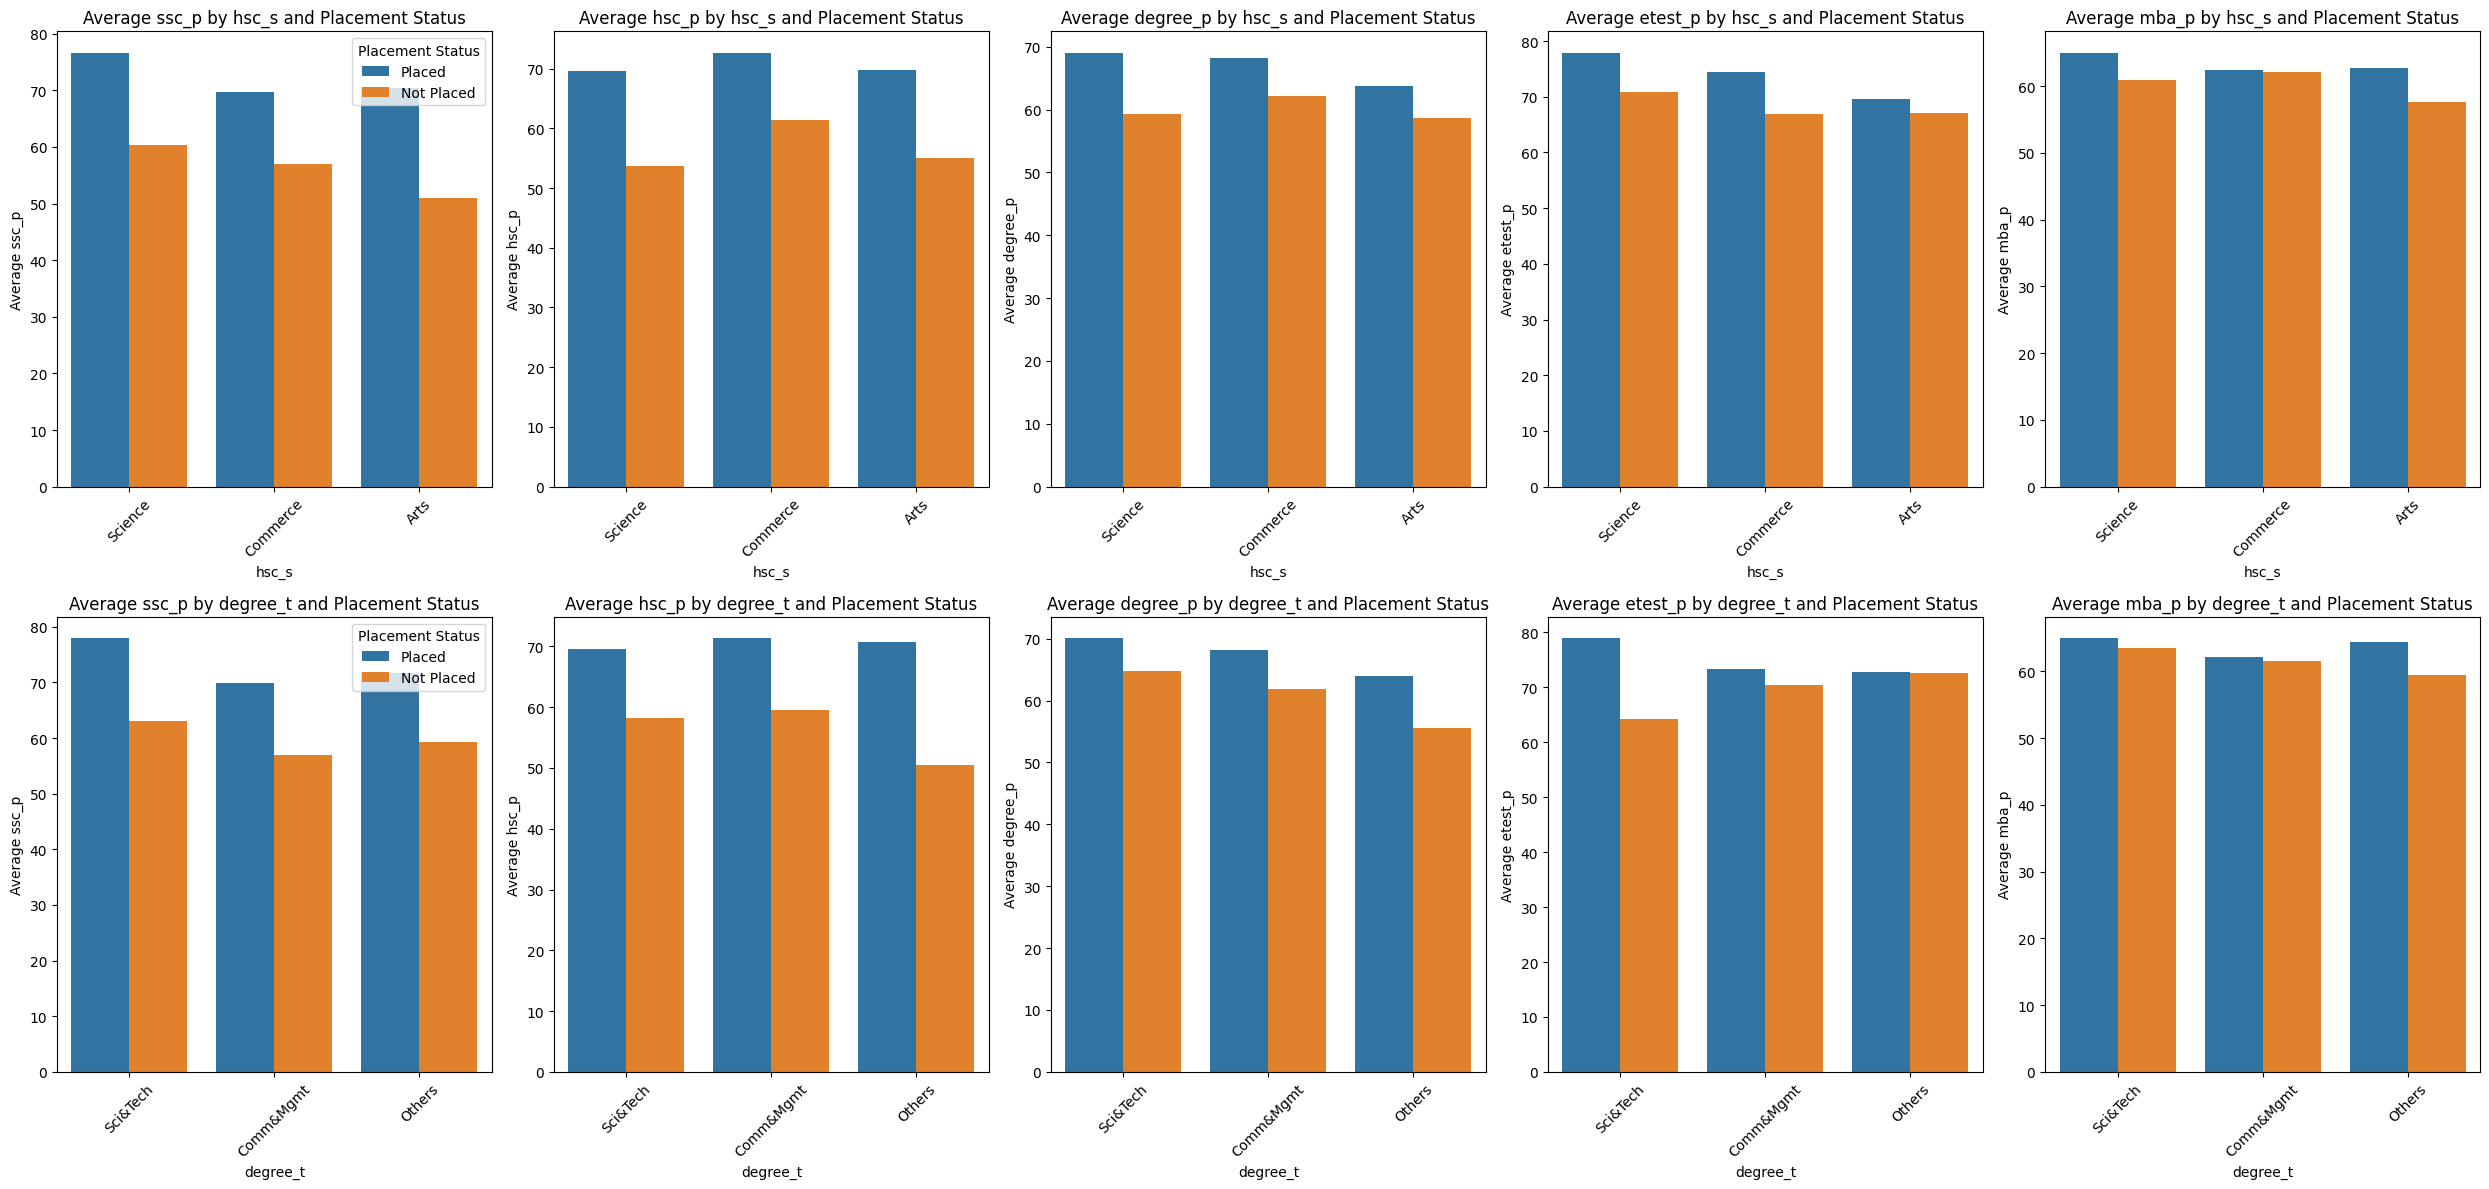

In [21]:
categories = ['hsc_s', 'degree_t']
numerical_columns = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']
fig, axes = plt.subplots(2, 5, figsize=(25, 12)) 
axes = axes.flatten()
plot_count = 0
for category in categories:
    for num_col in numerical_columns:
        sns.barplot(x=category, y=num_col, hue='status', data=campusDataset, ci=None, ax=axes[plot_count])
        axes[plot_count].set_title(f'Average {num_col} by {category} and Placement Status')
        axes[plot_count].set_ylabel(f'Average {num_col}')
        axes[plot_count].set_xlabel(category)
        axes[plot_count].tick_params(axis='x', rotation=45)
        if plot_count == 0 or plot_count == 5:
            axes[plot_count].legend(title='Placement Status')
        else:
            axes[plot_count].legend([],[], frameon=False)
        plot_count += 1
for i in range(plot_count, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


The bar plots you've shared provide insightful comparisons across different educational backgrounds and performance metrics, split by placement status. Here are the key insights:

1. **Higher Secondary School Stream (hsc_s)**:
   - **Science students** generally have higher scores across SSC, HSC, Degree, Etest, and MBA percentages and tend to be placed more often compared to other streams.
   - **Commerce students** have moderately high scores but show a noticeable variation in placement status, especially in Etest and MBA percentages.
   - **Arts students** generally have the lowest scores among the streams and exhibit lower placement rates, highlighting a potential disadvantage in placement success.

2. **Degree Type (degree_t)**:
   - **Science & Technology** students often score higher in SSC, HSC, and Etest percentages, and have a high placement rate. Their MBA scores are also quite competitive, suggesting strong overall academic and professional preparation.
   - **Commerce & Management** students display consistent scores but are less likely to be placed than Science & Technology students, especially noticeable in Etest scores.
   - **Others**: This category, likely encompassing diverse and less typical degrees, shows varied results but typically lower scores and placement rates in most metrics compared to Science & Technology.

**General Observations**:
- Across both higher secondary streams and degree types, there is a clear trend where higher academic scores correlate with higher placement rates.
- Placement success is significantly influenced by the stream of education and degree type, with Science & Technology students generally outperforming others.
- Etest and MBA scores show significant variability and could be crucial differentiators in placement success, particularly for Commerce students.

These insights suggest that educational background plays a crucial role in placement outcomes, and efforts to enhance student preparedness across all streams and degrees could be beneficial. Additionally, focusing on improving Etest and MBA performance might help increase placement rates, especially for students from less represented streams.

Cross-tabulation of Gender and Placement Status:
status  Not Placed  Placed
gender                    
F               36     159
M              195     280


Cross-tabulation of Work Experience and Placement Status:
status  Not Placed  Placed
workex                    
No             202     124
Yes             29     315




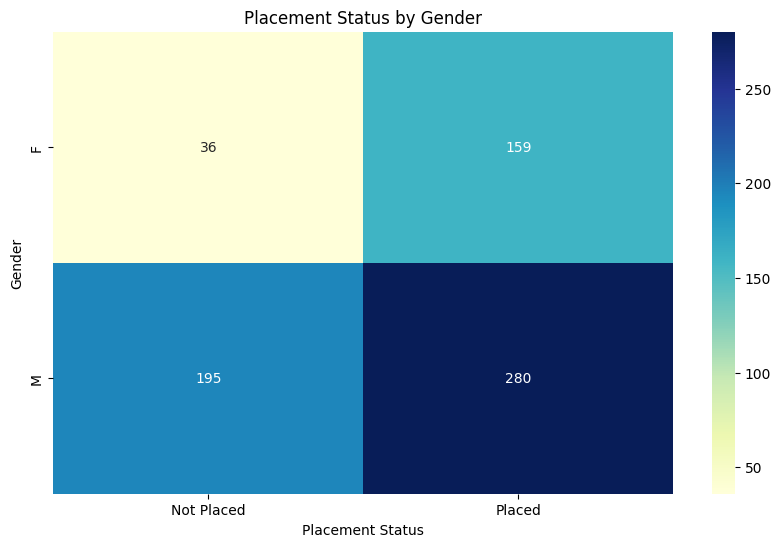

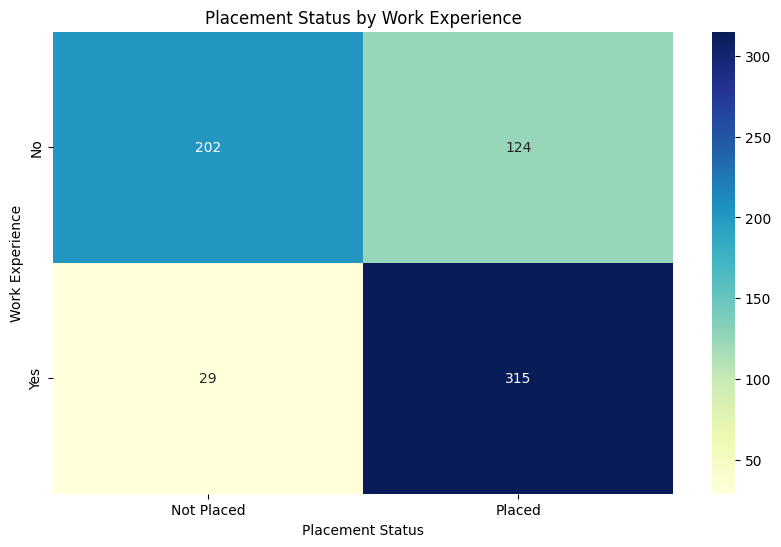

In [20]:
# Cross-tabulation of gender and placement status
gender_placement = pd.crosstab(index=campusDataset['gender'], columns=campusDataset['status'])
print("Cross-tabulation of Gender and Placement Status:")
print(gender_placement)
print("\n")

# Cross-tabulation of work experience and placement status
workex_placement = pd.crosstab(index=campusDataset['workex'], columns=campusDataset['status'])
print("Cross-tabulation of Work Experience and Placement Status:")
print(workex_placement)
print("\n")

# Optionally, you can visualize these cross-tabulations using seaborn's heatmap for better insight
plt.figure(figsize=(10, 6))
sns.heatmap(gender_placement, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Placement Status by Gender')

plt.ylabel('Gender')
plt.xlabel('Placement Status')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(workex_placement, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Placement Status by Work Experience')
plt.ylabel('Work Experience')
plt.xlabel('Placement Status')
plt.show()


The visuals provide these insights:

1. **Placement by Gender**:
   - Males have a higher total count and a higher placement rate compared to females. Both genders have a higher proportion of placements than non-placements.
   - The total number of placed males is significantly higher than that of females, suggesting either a higher number of male candidates or potentially better success rates among males in securing placements.

2. **Placement by Work Experience**:
   - Candidates with work experience have a much higher placement rate compared to those without. The proportion of placed candidates with work experience is notably higher.
   - Despite fewer candidates with work experience overall, their placement success is significantly greater, underscoring the value of experience in securing placements.

Text(0, 0.5, 'Count')

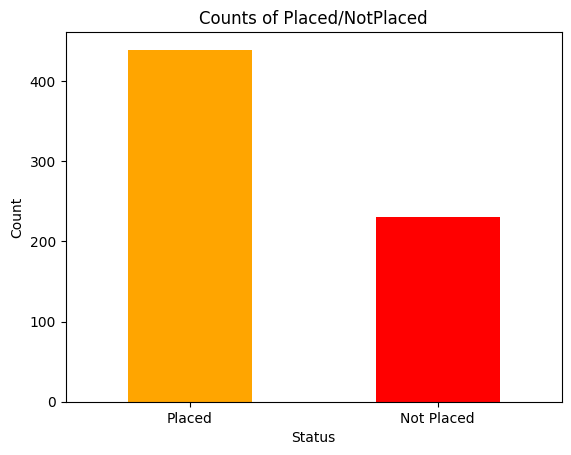

In [23]:
LABELS = ["Placed", "Not Placed"]
class_counts = pd.value_counts(campusDataset['status'], sort = True)
class_counts.plot(kind = 'bar', rot=0, color=['orange','red']) 
plt.title('Counts of Placed/NotPlaced')
plt.xticks(range(2), LABELS)
plt.xlabel("Status")
plt.ylabel("Count")

There are 439 instances of "Placed" and 231 instances of "Not Placed," according to the status variable's distribution. This suggests that the number of "Placed" instances is nearly twice that of "Not Placed" cases. Although there is an imbalance here, it is not a severe one. Because of its moderate degree of imbalance, extensive resampling approaches might not be necessary.

### Distribution of categories based on the target variable

In [24]:
degree_counts = campusDataset['degree_t'].value_counts()
degree_counts

degree_t
Sci&Tech     257
Comm&Mgmt    209
Others       204
Name: count, dtype: int64

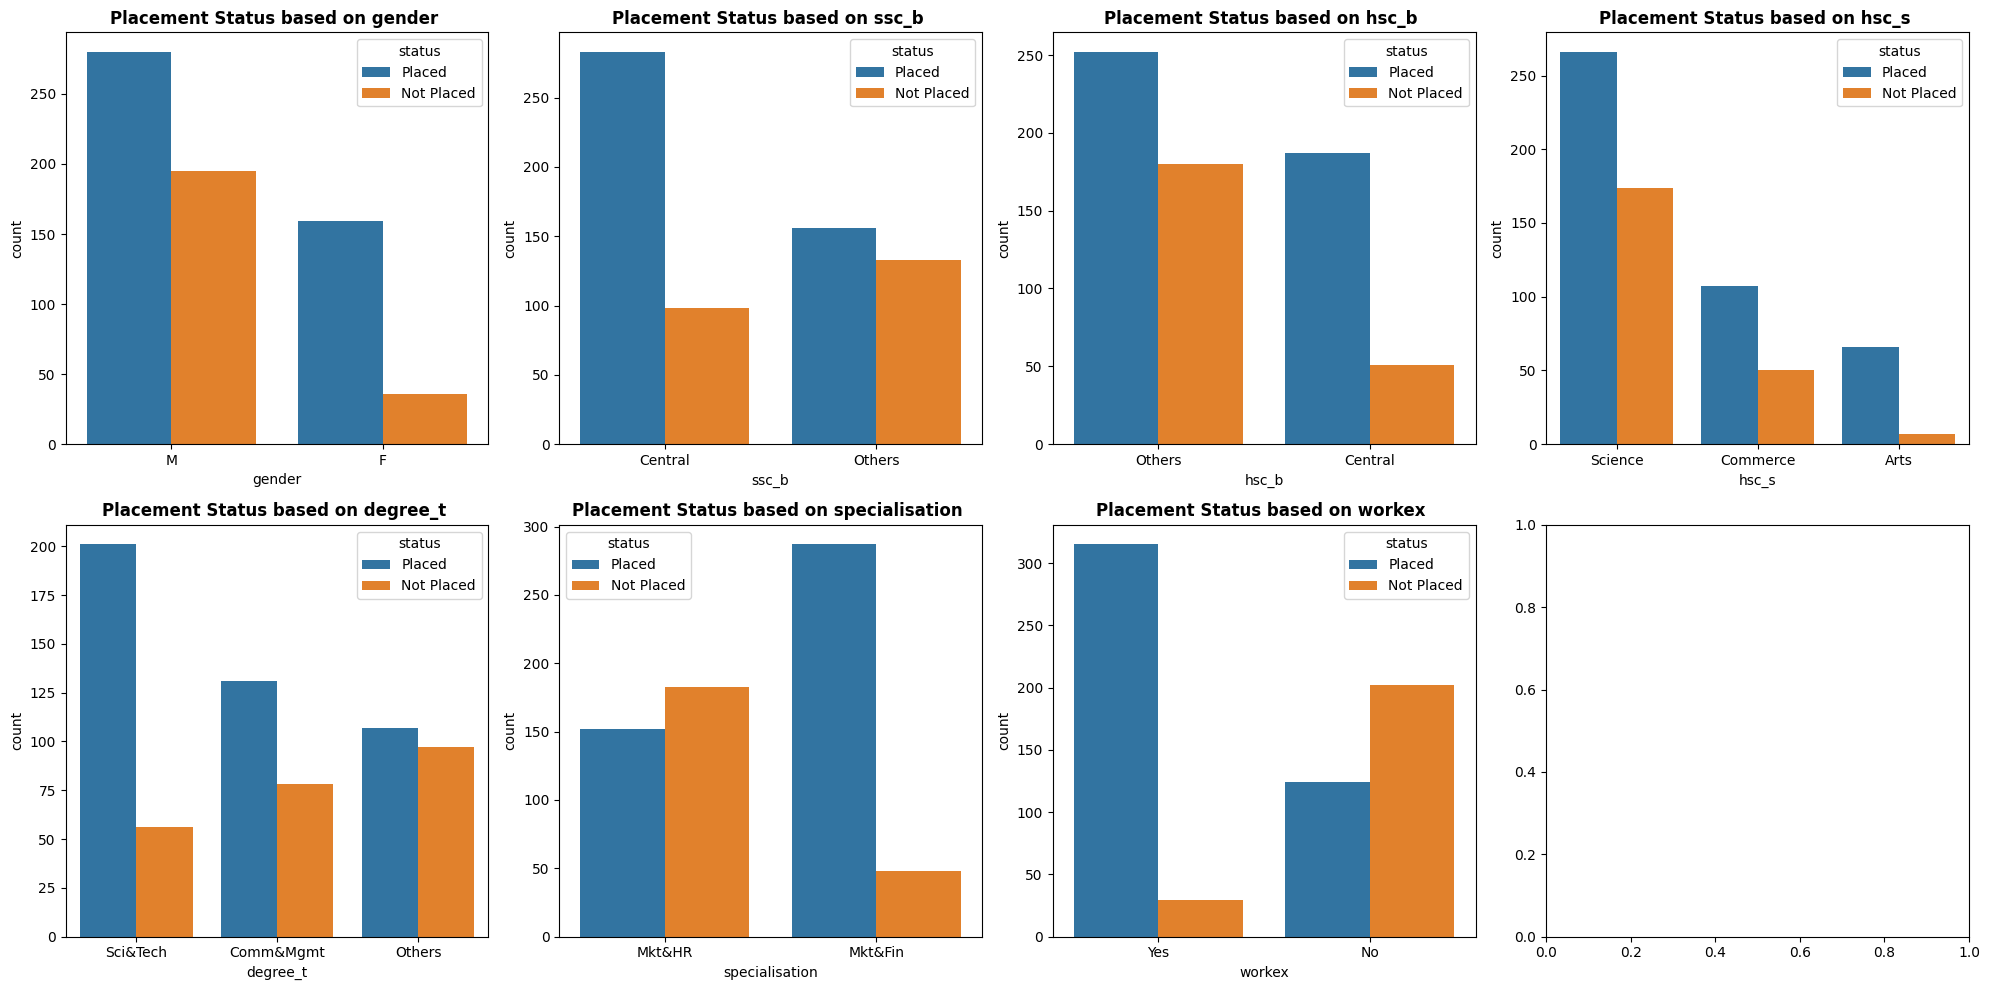

In [25]:
categorical_features = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'specialisation', 'workex']


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sb.countplot(x=feature, hue='status', data=campusDataset,  ax=axes[i])
    # sb.lineplot(x=campusDataset.index, y=feature, data=campusDataset, ax=axes[i])
    axes[i].set_title(f'Placement Status based on {feature} ',fontweight='bold')

plt.tight_layout()
plt.show()

Based on the bar plots:
- According to **SSC Board placement status (ssc_b)**, Central Board students appear to be placed more frequently than "Others" category students.
- According to **HSC Board placement(hsc_b)**, Central board students are placed at a higher rate than "Others," much like SSC Board students are.
- The Science **stream** has the greatest placement rate, followed by the Commerce stream, while the Arts stream has the lowest.
- **Degree Type (degree_t)** Placement Status: Students in the Science & Tech field are best placed, followed by those in the Communication & Management field, while "Others" have the lowest placements.
- Placement Status according to **Specialisation**: Students with a concentration in Mkt&Fin, appear to be placed more frequently than those with a concentration in Mkt&HR.
- **Work Experience**-Based Placement Status (workex): Students who report having work experience (Yes) are placed more frequently than those who report having none (No).

### **Preprocessing**

#### Missing Values

In [26]:
campusDataset.isnull().sum()

gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
etest_p           0
mba_p             0
specialisation    0
workex            0
status            0
dtype: int64

No null values present in the dataset so missing values do not need to be removed. 

In [27]:
campusDataset.describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,68.960017,65.203006,65.229034,73.740025,62.993108
std,10.182563,11.222577,7.157608,12.101840,5.126855
min,42.864579,37.106246,50.000000,50.000000,51.290000
25%,61.619318,60.431420,60.000000,64.199327,59.431996
50%,68.332563,64.753270,64.906329,72.677821,62.481656
75%,77.130019,71.390402,70.271632,83.955186,66.864202
max,89.400000,97.700000,91.000000,97.938047,77.890000


#### Outlier Detection

The maximum value of the all the features seems to be in a reasonable range. 

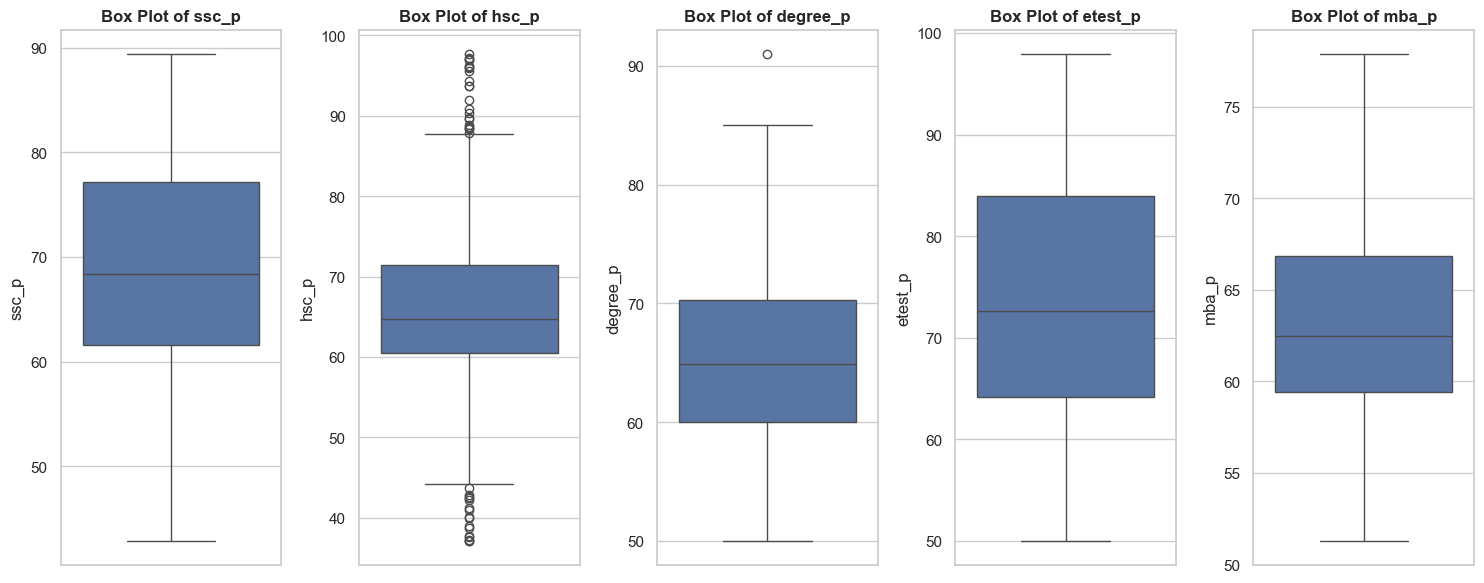

In [28]:
numerical_columns = campusDataset.select_dtypes(include=['float64', 'int64']).columns

num_cols = 5
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols
num_rows = 1 
plt.figure(figsize=(15, num_rows * 6))
sb.set(style="whitegrid") 

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sb.boxplot(y=campusDataset[column])
    plt.title(f'Box Plot of {column}',fontweight='bold')

plt.tight_layout()
plt.show()

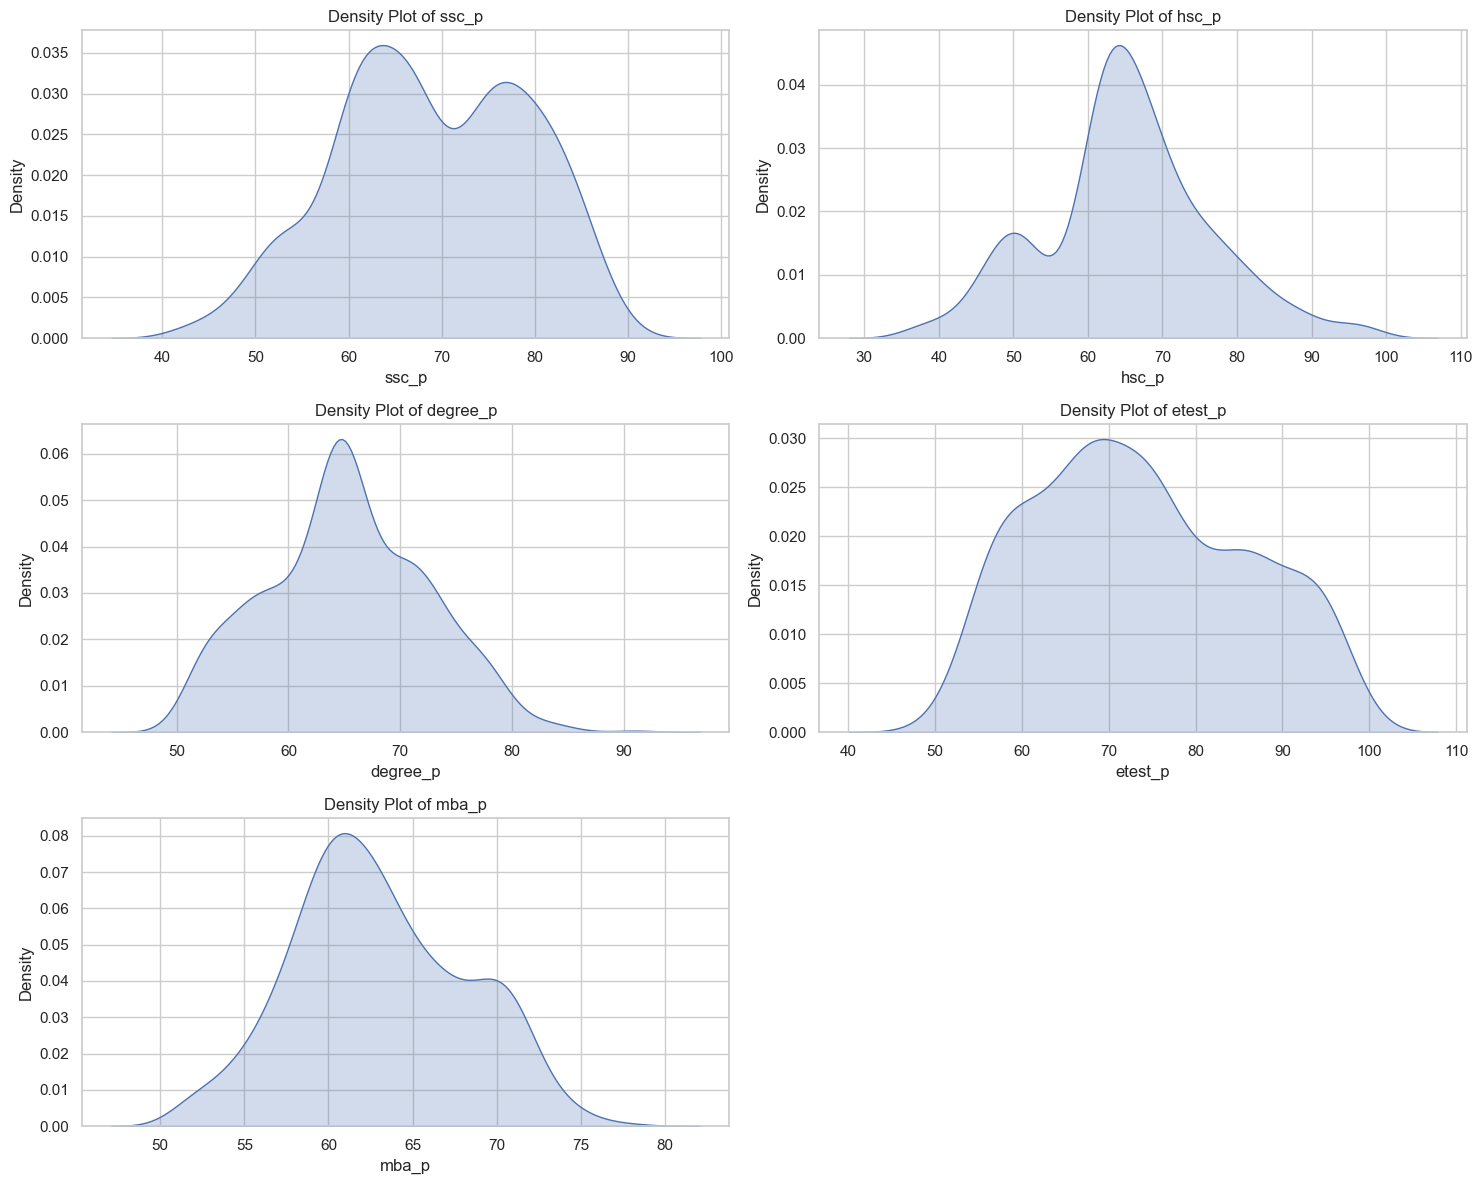

In [29]:
import seaborn as sns
numeric_cols = campusDataset.select_dtypes(include=['float64', 'int64'])
n_rows = (len(numerical_columns) + 1) // 2
fig, axs = plt.subplots(n_rows, 2, figsize=(15, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(numerical_columns):
    sns.kdeplot(campusDataset[col], ax=axs[i], fill=True)
    axs[i].set_title(f'Density Plot of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Density')

if len(numerical_columns) % 2 != 0:
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


Based on the density plots and box plots, there is no apparent skewness in any of the numerical columns. The distributions appear to be somewhat close to normalized.

### **Outlier removal**

Based on the boxplot of the feature hsc_p there seems to be the presence of some outliers. Based on the statistical measures the outliers do not seem to skew the distribution but may cause an issue during model training.

In [30]:
Q1 = campusDataset['hsc_p'].quantile(0.25)
Q3 = campusDataset['hsc_p'].quantile(0.75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

campus_cleaned = campusDataset[(campusDataset['hsc_p'] >= lower_whisker) & (campusDataset['hsc_p'] <= upper_whisker)]


In [31]:
campus_cleaned.head(10)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,etest_p,mba_p,specialisation,workex,status
0,M,73.976975,Central,77.392691,Others,Science,73.623151,Sci&Tech,84.498310,67.207006,Mkt&HR,Yes,Placed
1,M,62.000000,Others,62.000000,Others,Commerce,60.000000,Comm&Mgmt,63.000000,52.380000,Mkt&HR,Yes,Placed
2,M,80.965242,Others,67.104275,Others,Science,72.482621,Sci&Tech,91.343588,71.392313,Mkt&Fin,No,Placed
3,M,52.000000,Others,65.000000,Others,Arts,57.000000,Others,75.000000,59.810000,Mkt&Fin,Yes,Not Placed
4,F,69.000000,Central,62.000000,Central,Science,66.000000,Sci&Tech,75.000000,67.990000,Mkt&HR,No,Not Placed
5,M,78.762370,Others,78.663054,Others,Commerce,70.281069,Comm&Mgmt,67.441772,65.318049,Mkt&Fin,Yes,Placed
7,M,59.805924,Central,61.451481,Others,Commerce,60.000000,Comm&Mgmt,62.451481,57.025957,Mkt&HR,Yes,Placed
8,M,77.351318,Central,74.834674,Others,Science,73.487712,Sci&Tech,80.123994,68.001657,Mkt&HR,Yes,Placed
10,M,60.961359,Others,49.382702,Others,Science,54.503538,Others,70.376801,61.726117,Mkt&HR,No,Not Placed
11,F,73.809211,Central,81.213816,Central,Arts,58.657928,Others,59.233553,63.180197,Mkt&HR,Yes,Placed


Removed 37 records after removing outliers from the data

Mapping the target class to binary representation

In [32]:
campus_cleaned['status'] = campus_cleaned['status'].replace({'Placed':1, 'Not Placed':0})

In [33]:
value_counts = campus_cleaned['status'].value_counts()
value_counts

status
1    418
0    215
Name: count, dtype: int64

### **One hot encoding**
One-hot encoding is appropriate for nominal variables (without inherent ordering), like gender, ssc_b, hsc_b, hsc_s, specialisation, and workex, since it does not impose ordinality that does not exist.

Performing One hot encoding to covert categorical data to numerical

In [34]:
campus_encoded = pd.get_dummies(campus_cleaned)
campus_encoded = campus_encoded.astype(int)

In [35]:
campus_encoded.head(10)

,ssc_p,hsc_p,degree_p,etest_p,mba_p,status,gender_F,gender_M,ssc_b_Central,ssc_b_Others,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,specialisation_Mkt&Fin,specialisation_Mkt&HR,workex_No,workex_Yes
0,73,77,73,84,67,1,0,1,1,0,...,0,0,1,0,0,1,0,1,0,1
1,62,62,60,63,52,1,0,1,0,1,...,0,1,0,1,0,0,0,1,0,1
2,80,67,72,91,71,1,0,1,0,1,...,0,0,1,0,0,1,1,0,1,0
3,52,65,57,75,59,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,1
4,69,62,66,75,67,0,1,0,1,0,...,0,0,1,0,0,1,0,1,1,0
5,78,78,70,67,65,1,0,1,0,1,...,0,1,0,1,0,0,1,0,0,1
7,59,61,60,62,57,1,0,1,1,0,...,0,1,0,1,0,0,0,1,0,1
8,77,74,73,80,68,1,0,1,1,0,...,0,0,1,0,0,1,0,1,0,1
10,60,49,54,70,61,0,0,1,0,1,...,0,0,1,0,1,0,0,1,1,0
11,73,81,58,59,63,1,1,0,1,0,...,1,0,0,0,1,0,0,1,0,1


#### Analyzing the correlations between the variables

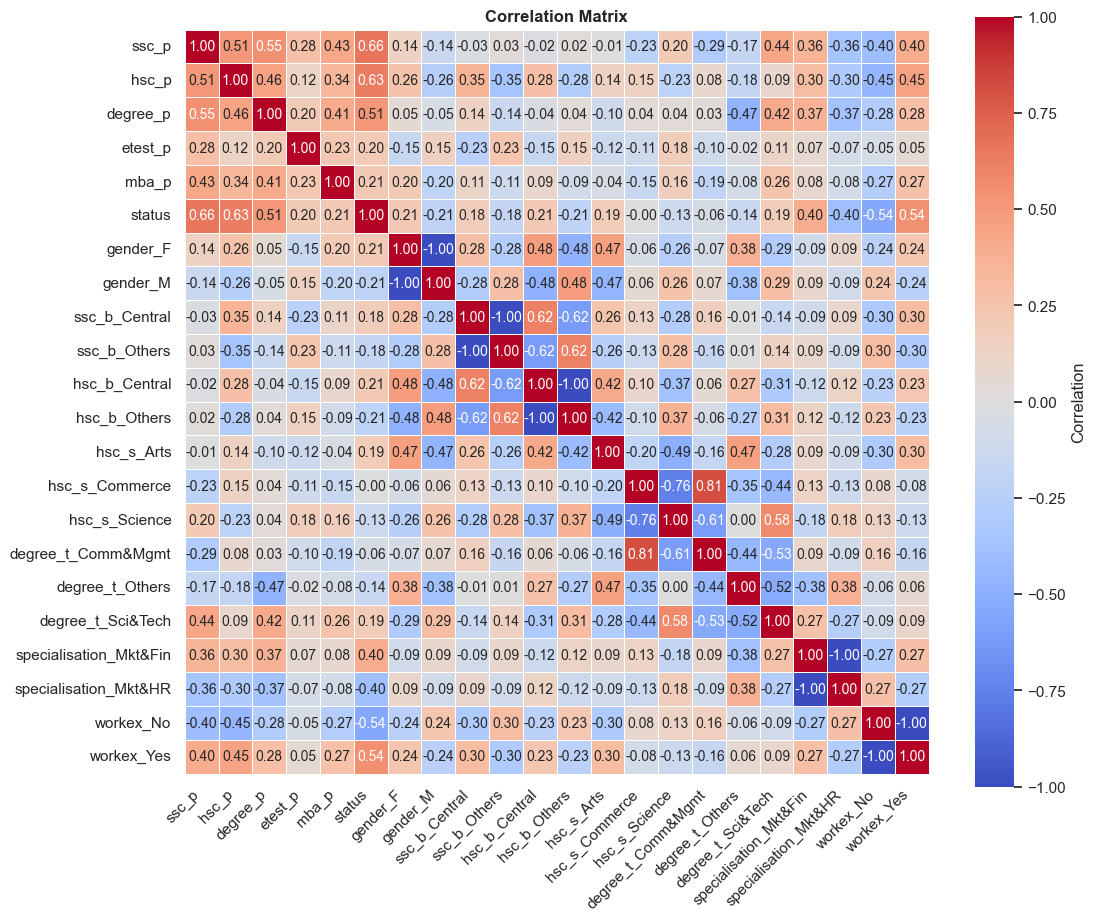

In [36]:
correlation_matrix = campus_encoded.corr()

plt.figure(figsize=(12, 10))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, cbar_kws={'label': 'Correlation'}, annot_kws={'size': 10}, square=True)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0) 
plt.title('Correlation Matrix',fontweight='bold')
plt.show()

The correlation matrix offers several key observations about the relationships between academic scores, demographic factors, and placement status:
1. **Strong Correlations with Placement Status**:
   - `ssc_p` (secondary school percentage) and `hsc_p` (higher secondary school percentage) show strong positive correlations with placement status (0.66 and 0.63 respectively), indicating that higher academic scores in school are good predictors of getting placed.
   - `degree_p` (degree percentage) also shows a notable positive correlation (0.51) with placement status, underscoring the importance of good academic performance in college for placement prospects.

2. **Work Experience**:
   - Work experience (`workex_Yes`) has a significant positive correlation (0.54) with placement status, suggesting that candidates with prior work experience are more likely to get placed than those without.

3. **Gender Differences**:
   - Gender shows a notable correlation with placement status, with males (`gender_M`) having a slight positive correlation (0.26), indicating a higher likelihood of being placed compared to females.

4. **Field of Study**:
   - Specific fields of study show different correlations with placement status. For instance, students from the Science stream (`hsc_s_Science`) and those in Sci & Tech degree programs (`degree_t_Sci&Tech`) show positive correlations with placement status (0.37 and 0.31 respectively), suggesting these fields may have better placement rates.
   - Commerce students (`hsc_s_Commerce`) and Management degrees (`degree_t_Comm&Mgmt`) show weaker but positive correlations with placement status.

5. **Specialisation**:
   - Specialisation in Marketing & Finance (`specialisation_Mkt&Fin`) shows a positive correlation (0.27) with placement status, indicating that candidates from this specialization tend to have better placement outcomes compared to those in Marketing & HR.

6. **Academic Boards**:
   - There are minimal correlations between the educational boards (`ssc_b` and `hsc_b`) and placement status, indicating that the board of education in secondary and higher secondary levels does not significantly influence placement outcomes.

These insights can help in identifying the factors that are most influential in determining placement success, which can be crucial for academic advising, student counseling, and policy-making in educational institutions.

In [37]:
correlation5 = correlation_matrix['status'].abs().sort_values(ascending=False).head(8)[1:]
print(correlation5)


ssc_p                     0.662810
hsc_p                     0.631982
workex_No                 0.543169
workex_Yes                0.543169
degree_p                  0.509716
specialisation_Mkt&HR     0.395718
specialisation_Mkt&Fin    0.395718
Name: status, dtype: float64


The top 5 correlated features to students placed are - ssc_p, hsc_p, workex, degree, specialization

### **Feature Identification**

In [38]:
# Assuming correlation_matrix is already calculated
selected_features = correlation_matrix['status'].abs().sort_values(ascending=False).drop('status').head(5).index.tolist()

# Display the selected features to verify
print("Selected Features based on highest correlations:")
print(selected_features)


Selected Features based on highest correlations:
['ssc_p', 'hsc_p', 'workex_No', 'workex_Yes', 'degree_p']


### **Feature Extraction**

In [39]:
campus_encoded['education_attainment'] = (campus_encoded['ssc_p'] + campus_encoded['hsc_p'] + campus_encoded['degree_p']) / 3
campus_encoded['education_attainment'] = campus_encoded['education_attainment'].round().astype(int)

# Final dataset with selected and engineered features
final_data = campus_encoded[selected_features + ['education_attainment', 'status']]
final_data = final_data.drop(['ssc_p', 'hsc_p', 'degree_p'], axis=1)

In [40]:
final_data.head(10)

,workex_No,workex_Yes,education_attainment,status
0,0,1,74,1
1,0,1,61,1
2,1,0,73,1
3,0,1,58,0
4,1,0,66,0
5,0,1,75,1
7,0,1,60,1
8,0,1,75,1
10,1,0,54,0
11,0,1,71,1


### **Splitting the dataset**

In [41]:
X = final_data.drop('status', axis=1)  
y = final_data['status']               

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Support Vector Machine (SVM)**

In [44]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_predictions)

In [45]:
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)
print(f"Support Vector Machine Confusion Matrix:\n{svm_confusion_matrix}")

Support Vector Machine Confusion Matrix:
[[38  5]
 [ 8 76]]


In [46]:
svm_report = classification_report(y_test, svm_predictions, target_names=['Not Placed', 'Placed'])
print(f"Support Vector Machine (SVM) Classification Report:\n{svm_report}\n")
print(f"SVM Accuracy: {svm_accuracy}")

Support Vector Machine (SVM) Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.83      0.88      0.85        43
      Placed       0.94      0.90      0.92        84

    accuracy                           0.90       127
   macro avg       0.88      0.89      0.89       127
weighted avg       0.90      0.90      0.90       127


SVM Accuracy: 0.8976377952755905


### **Logistic Regression**

In [47]:
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg_model.predict(X_test_scaled)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [48]:
log_reg_confusion_matrix = confusion_matrix(y_test, log_reg_predictions)
print(f"Logistic Regression Confusion Matrix:\n{log_reg_confusion_matrix}")

Logistic Regression Confusion Matrix:
[[38  5]
 [ 8 76]]


In [49]:
log_reg_report = classification_report(y_test, log_reg_predictions, target_names=['Not Placed', 'Placed'])
print(f"Logistic Regression Classification Report:\n{log_reg_report}\n")
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.83      0.88      0.85        43
      Placed       0.94      0.90      0.92        84

    accuracy                           0.90       127
   macro avg       0.88      0.89      0.89       127
weighted avg       0.90      0.90      0.90       127


Logistic Regression Accuracy: 0.8976377952755905


### **GaussianNB**

In [50]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)

In [51]:
nb_confusion_matrix = confusion_matrix(y_test, nb_predictions)
print(f"Naive Bayes Confusion Matrix:\n{nb_confusion_matrix}")

Naive Bayes Confusion Matrix:
[[38  5]
 [15 69]]


In [52]:
nb_report = classification_report(y_test, nb_predictions, target_names=['Not Placed', 'Placed'])
print(f"Naive Bayes Classification Report:\n{nb_report}\n")
print(f"Naive Bayes Accuracy: {nb_accuracy}")

Naive Bayes Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.72      0.88      0.79        43
      Placed       0.93      0.82      0.87        84

    accuracy                           0.84       127
   macro avg       0.82      0.85      0.83       127
weighted avg       0.86      0.84      0.85       127


Naive Bayes Accuracy: 0.84251968503937


### **Decision Trees**

In [53]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)

In [54]:
dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)
print(f"Decision Tree Confusion Matrix:\n{dt_confusion_matrix}")

Decision Tree Confusion Matrix:
[[36  7]
 [ 5 79]]


In [55]:
dt_report = classification_report(y_test, dt_predictions, target_names=['Not Placed', 'Placed'])
print(f"Decision Tree Classification Report:\n{dt_report}\n")
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.88      0.84      0.86        43
      Placed       0.92      0.94      0.93        84

    accuracy                           0.91       127
   macro avg       0.90      0.89      0.89       127
weighted avg       0.90      0.91      0.90       127


Decision Tree Accuracy: 0.905511811023622


In [56]:
data = [
    ["Support Vector Machine (SVM)", svm_report, svm_accuracy],
    ["Logistic Regression", log_reg_report, log_reg_accuracy]
]

headers = ["Model", "Classification Report", "Accuracy"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+------------------------------+-------------------------------------------------------+------------+
| Model                        | Classification Report                                 |   Accuracy |
+==============================+=======================================================+============+
| Support Vector Machine (SVM) | precision    recall  f1-score   support               |   0.897638 |
|                              |                                                       |            |
|                              |   Not Placed       0.83      0.88      0.85        43 |            |
|                              |       Placed       0.94      0.90      0.92        84 |            |
|                              |                                                       |            |
|                              |     accuracy                           0.90       127 |            |
|                              |    macro avg       0.88      0.89      0.89      

In [57]:
data = [
    ["Naive Bayes", nb_report, nb_accuracy],
    ["Decision Tree", dt_report, dt_accuracy]
]

headers = ["Model", "Classification Report", "Accuracy"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+---------------+-------------------------------------------------------+------------+
| Model         | Classification Report                                 |   Accuracy |
+===============+=======================================================+============+
| Naive Bayes   | precision    recall  f1-score   support               |   0.84252  |
|               |                                                       |            |
|               |   Not Placed       0.72      0.88      0.79        43 |            |
|               |       Placed       0.93      0.82      0.87        84 |            |
|               |                                                       |            |
|               |     accuracy                           0.84       127 |            |
|               |    macro avg       0.82      0.85      0.83       127 |            |
|               | weighted avg       0.86      0.84      0.85       127 |            |
+---------------+--------------------------

### Observations:

1. **Overall Accuracy**:
   - The **Decision Tree** model shows the highest accuracy (90.55%), closely followed by the **Support Vector Machine (SVM)** and **Logistic Regression** models (both at 89.76%).
   - The **Naive Bayes** model has the lowest accuracy (84.25%), which might be due to its assumption of feature independence that may not hold true in this dataset.

2. **Precision and Recall**:
   - **SVM** and **Logistic Regression** models show excellent precision for the "Placed" class (0.94), indicating a high likelihood of correct predictions when a student is predicted as placed.
   - **Decision Tree** provides the best balance between precision and recall for both classes, suggesting a good trade-off between the number of false positives and false negatives.
   - **Naive Bayes**, despite its lower overall accuracy, achieves a high recall (0.88) for the "Not Placed" class, indicating it is good at identifying most of the actual negatives.

3. **F1-Score**:
   - The F1-score, which is a harmonic mean of precision and recall, is consistently high for the "Placed" class across all models, particularly in the SVM and Logistic Regression models (0.92).
   - The Decision Tree model shows strong F1-scores for both classes, making it robust in terms of balanced performance.

### Strategies for Improvement:

1. **Targeted Academic Support**
- **Focus on Key Subjects:** Insights suggest significant differences in placement outcomes based on performance in specific educational backgrounds (SSC, HSC, Degree). Implement targeted academic support or remedial classes for students underperforming in critical subjects.
- **Enhanced Counseling:** Provide personalized academic counseling for students, especially those from the arts background or those with lower scores, to improve their educational outcomes.

2. **Career Guidance and Work Experience**
- **Internship Programs:** Encourage or mandate internships, as work experience has shown to significantly influence placement outcomes. Partnerships with industries for internships can provide practical experience, making students more attractive to employers.
- **Career Workshops:** Regular workshops on career awareness can help students understand the range of available job opportunities and the expectations of different industries.

3. **Skill Development Programs**
- **Soft Skills Training:** Given the importance of MBA scores, which likely include assessments of management and soft skills, implement comprehensive soft skills training programs focusing on communication, leadership, and teamwork.
- **Technical Skills Enhancement:** Offer additional courses or workshops in high-demand skills relevant to the job market, particularly for students in technical degree tracks.

4. **Alumni Networking and Mentorship**
- **Alumni Engagement:** Leverage alumni networks to provide mentorship, networking opportunities, and even job placements for current students. Alumni can offer valuable insights and real-world advice to help prepare students for their careers.
- **Mentorship Programs:** Establish mentorship programs where senior students and alumni can guide juniors through the academic and career planning processes.

5. **Placement Training**
- **Mock Interviews and Resume Workshops:** Organize regular sessions on resume writing, interview preparation, and aptitude tests. These should be tailored to meet the major recruiting criteria used by companies.
- **Company-Specific Training:** If certain companies are major recruiters, tailor training sessions to meet these companies' specific requirements, helping students understand and prepare for these opportunities better.

6. **Feedback Mechanisms**
- **Continuous Feedback:** Implement a system for continuous feedback from students regarding the effectiveness of the training and support services provided, allowing for real-time improvements.
- **Outcome Tracking:** Monitor the success of various initiatives over time to adjust strategies as needed based on what is most effective at improving placement rates.

By implementing these strategies, educational institutions can not only improve the placement rates but also enhance the overall educational experience and readiness of students for their professional careers.